# SDSSRM-XCS gas fraction: Evolution with mass?

This section of the project uses the properties measured in the first paper of this series [(Turner et al. 2024)](https://ui.adsabs.harvard.edu/abs/2025MNRAS.tmp...10T/abstract), specifically total/hydrostatic mass ($M_{\rm{tot}}$, or $M^{\rm{tot}}_{\Delta}$ within an overdensity radius $R_{\Delta}$), and hot gas mass of galaxy clusters and groups ($M_{\rm{gas}}$, or $M^{\rm{gas}}_{\Delta}$), to measure the gas fraction ($f_{\rm{gas}}$). This is ratio of mass contained in the hot ICM, to the overall halo mass, and in a perfect Universe would be 'set' just by the Universe's overall baryon fraction.

That is a simplification however, and in reality a whole host of factors contribute to shifting cluster $f_{\rm{gas}}$ from the cosmic value, not least of which is the fact that in **this measurement** we are not taking into account all the baryons in a cluster (some are locked in galaxies/stars, some are in cooler phases of the ICM). Other factors include feedback processes, which can have outsized effects on lower-mass clusters and groups, causing their hot ICM to 'puff up' and be pushed to the very outskirts of the halo. Previous work has identified an evolution of the baryon fraction with halo mass.

As the first paper of this series produced a dataset with measures of the total and hot-gas masses, and we have already measured $M_{\rm{tot}}$-$M_{\rm{gas}}$ scaling relations, we take this opportunity to make a new measure of the gas fraction in clusters

Scaling relation fits were performed using the XGA interface to the R scaling-relation fitting package LIRA, see the paper for full details.

## Main takeaways

In summary:

* We calculate $f_{\rm{gas}}$ distributions within $R_{2500}$ and $R_{500}$, using hydrostatic and gas masses from the first paper in this series. The $R_{2500}$ and $R_{500}$ distributions contains **91** and **104** clusters respectively.
* 

## Import Statements

In [1]:
from astropy.units import Quantity
from astropy.cosmology import Planck18
import numpy as np
import pickle
import matplotlib.pyplot as plt
import pandas as pd

# This adds the directory above to the path, allowing me to import the common functions that I've written in
#  common.py - this just saves me repeating boring code and makes sure its all consistent
import sys
sys.path.insert(0, '..')
from common import xcs_cosmo, mgas_norm, m_norm

import xga
from xga.relations.fit import scaling_relation_lira

## Loading data files and relations

We load the new SDSSRM-XCS scaling relations between total mass and gas mass, as they contain all the information required to calculate the gas fractions for the SDSSRM-XCS galaxy clusters. The relation data points will be used to create an $f_{\rm{gas}}$ distribution, and the relation fit models will constrain any mass evolution.

The SDSSRM-XCS sample/results files are also loaded, so that output gas fraction measurement files can have an entry for every cluster in the SDSSRM-XCS sample, even if we couldn't calculate an $f_{\rm{gas}}$ value because of a lack of cluster mass measurement.

### SDSSRM-XCS base sample

In [2]:
sdssxcs_base = pd.read_csv("../../sample_files/SDSSRM-XCS_base_sample.csv")
sdssxcs_base.head(6)

,name,MEM_MATCH_ID,xapa_ra,xapa_dec,rm_ra,rm_dec,z,r500,r500-,r500+,richness,richness_err,XCS_NAME,R_LAMBDA,xmm_targeted,xmm_serendipitous
0,SDSSXCS-124,124,0.80058,-6.09182,0.798261,-6.091694,0.2475,1181.028,21.202,23.203,109.550,4.490,XMMXCS J000312.1-060530.5,1.018410,Y,NaN
1,SDSSXCS-2789,2789,0.95554,2.06802,0.956981,2.066469,0.1053,1007.861,17.194,17.202,38.904,2.830,XMMXCS J000349.3+020404.8,0.827942,Y,NaN
2,SDSSXCS-290,290,2.72264,29.16102,2.714137,29.161154,0.3485,913.052,30.879,31.210,105.096,5.994,XMMXCS J001053.4+290939.6,1.009990,Y,NaN
3,SDSSXCS-1018,1018,4.40633,-0.87619,4.406711,-0.878340,0.2144,902.259,22.445,23.366,56.997,3.219,XMMXCS J001737.5-005234.2,0.893655,NaN,Y
4,SDSSXCS-134,134,4.90839,3.60982,4.911069,3.599257,0.2773,1123.321,19.219,19.226,108.604,4.792,XMMXCS J001938.0+033635.3,1.016645,Y,NaN
5,SDSSXCS-119,119,8.46470,-7.86290,8.471426,-7.869543,0.3042,944.275,46.422,46.747,128.192,5.697,XMMXCS J003351.5-075146.4,1.050926,Y,NaN


Calculating E(z) values for these clusters:

In [ ]:
sdssxcs_base['E'] = xcs_cosmo.efunc(sdssxcs_base['z'].values)

### SDSSRM-XCS $T_{\rm{X}}$ and $L_{\rm{X}}$

In [ ]:
sdssxcs_txlx = pd.read_csv("../../sample_files/paper_one_results/sdssrm-xcs_txlx_v1.0.0.csv")
sdssxcs_txlx.head(6)

### SDSSRM-XCS masses

In [ ]:
sdssxcs_mass = pd.read_csv("../../sample_files/paper_one_results/sdssrm-xcs_mass_v1.0.0.csv")
sdssxcs_mass.head(6)

### Combining tables

In [ ]:
sdssxcs_samp = pd.merge(sdssxcs_base, sdssxcs_txlx, left_on='name', right_on='name', how='outer')
sdssxcs_samp = pd.merge(sdssxcs_samp, sdssxcs_mass, left_on='name', right_on='name', how='outer')

### $M^{\rm{tot}}_{500}$-$M^{\rm{gas}}_{500}$

In [3]:
with open('../../outputs/scaling_relations/sdssrm-xcs_new/mtot-mgas/turner2025_mtot500_mgas500.xgarel', 'rb') as scalo:
    mtot500_mgas500 = pickle.load(scalo)

### $M^{\rm{tot}}_{2500}$-$M^{\rm{gas}}_{2500}$

In [4]:
with open('../../outputs/scaling_relations/sdssrm-xcs_new/mtot-mgas/turner2025_mtot2500_mgas2500.xgarel', 'rb') as scalo:
    mtot2500_mgas2500 = pickle.load(scalo)

## Calculating $f_{\rm{gas}}$ distributions

We measure the $f_{\rm{gas}}$ value for the galaxy clusters in the new SDSSRM-XCS $M_{\rm{tot}}$-$M_{\rm{gas}}$ scaling relations - this results in two distributions, one for $f_{\rm{gas}}$ within $R_{2500}$ and another for $f_{\rm{gas}}$ within $R_{500}$. We make no attempt to measure an evolution of $f_{\rm{gas}}$ with halo mass at this point.

In [5]:
# Measuring gas fractions is a simple calculation thankfully - propagate errors ASSUMING NO COVARIANCE WHICH IS PROBABLY DAFT
gfrac_2500 = mtot2500_mgas2500.x_data[:, 0]/mtot2500_mgas2500.y_data[:, 0]
gfrac_2500_err = np.sqrt(((1/(mtot2500_mgas2500.y_data[:, 0])**2)*mtot2500_mgas2500.x_data[:, 1]**2) + 
                         ((mtot2500_mgas2500.x_data[:, 0]**2 / mtot2500_mgas2500.y_data[:, 0]**4)*mtot2500_mgas2500.y_data[:, 1]**2))

gfrac_500 = mtot500_mgas500.x_data[:, 0]/mtot500_mgas500.y_data[:, 0]
gfrac_500_err = np.sqrt(((1/(mtot500_mgas500.y_data[:, 0])**2)*mtot500_mgas500.x_data[:, 1]**2) + 
                        ((mtot500_mgas500.x_data[:, 0]**2 / mtot500_mgas500.y_data[:, 0]**4)*mtot500_mgas500.y_data[:, 1]**2))

### Visualizing the distributions

In [6]:
# Set up the bins for the fgas histogram; 0-1 in 0.025 wide steps
frac_bins = np.linspace(0, 1, 41)

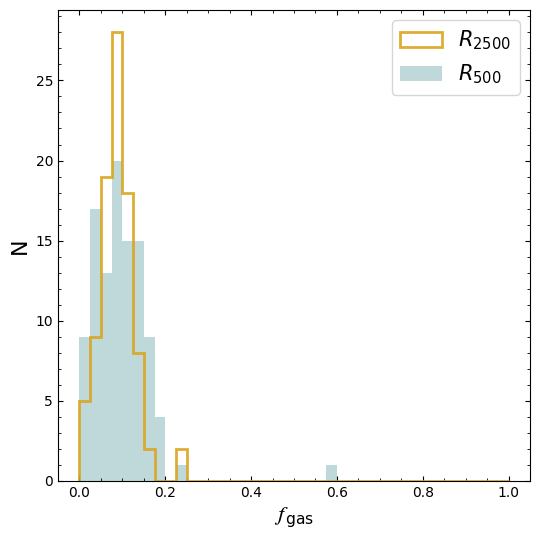

In [39]:
plt.figure(figsize=(5.5, 5.5))
plt.minorticks_on()
plt.tick_params(which='both', direction='in', top=True, right=True)

plt.hist(gfrac_2500, bins=frac_bins, color='goldenrod', alpha=0.9, histtype='step', label=r'$R_{2500}$', linewidth=2)
plt.hist(gfrac_500, bins=frac_bins, color='cadetblue', alpha=0.4, histtype='stepfilled', label=r'$R_{500}$')

plt.xlabel(r"$𝑓_{\rm{gas}}$", fontsize=16)
plt.ylabel(r"N", fontsize=16)

plt.legend(fontsize=15)
plt.tight_layout()
# plt.savefig("../../outputs/figures/gas_fraction/gas_frac_dist.pdf")
plt.show()

### Outputting gas $f_{\rm{gas}}$ values

We save the calculated $f_{\rm{gas}}$ values to a results file:

In [8]:
fgas500_dat = np.vstack([mtot500_mgas500.point_names, gfrac_500.round(3).value, gfrac_500_err.round(3).value]).T
fgas500_col = ['name', 'fgas500', 'fgas500+-']
fgas500_df = pd.DataFrame(fgas500_dat, columns=fgas500_col)

fgas2500_dat = np.vstack([mtot2500_mgas2500.point_names, gfrac_2500.round(3).value, gfrac_2500_err.round(3).value]).T
fgas2500_col = ['name', 'fgas2500', 'fgas2500+-']
fgas2500_df = pd.DataFrame(fgas2500_dat, columns=fgas2500_col)

fgas_df = pd.merge(sdssxcs_base[['name', 'z']], fgas500_df, on='name', how='outer')
fgas_df = pd.merge(fgas_df, fgas2500_df, on='name', how='outer')
fgas_df.to_csv("../../outputs/result_files/gas_fractions.csv", index=False)

## Gas fraction $z$ dependence

Though this project did not set out to examine the redshift dependence of SDSSRM-XCS scaling relations, as the redshift range is limited, we can examine the new SDSSRM-XCS $M_{\rm{tot}}$- $M_{\rm{gas}}$ relations in the context of each data point's redshift (some previous work has found a change of $f_{\rm{gas}}$ with redshift).

### $M^{\rm{tot}}_{500}$-$M^{\rm{gas}}_{500}$

In [10]:
# As the relation is not guaranteed to contain all the data points in the same file, nor to necessarily be in the same order, we 
#  use this search-sorted trick to get the indices in the base sample that correspond to the names given to each datapoint when 
#  the scaling relation was constructed
sort_rel_names = np.argsort(sdssxcs_base['name'].values)
pnt_samp_ind = sort_rel_names[np.searchsorted(sdssxcs_base['name'].values, mtot500_mgas500.point_names, sorter=sort_rel_names)]

# Reads out cluster redshifts, in the right order!
redshifts = sdssxcs_base.loc[pnt_samp_ind, 'z'].values
# Don't recommend setting attributes directly, but apparently I never added property setters for these when I 
#  wrote this class
mtot500_mgas500._third_dim_info = redshifts
mtot500_mgas500._third_dim_name = r"$z$"

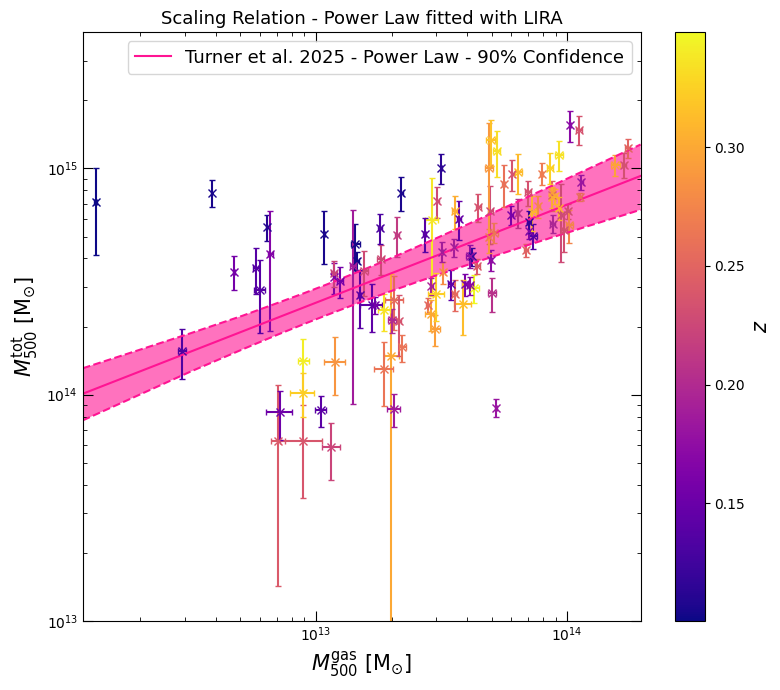

In [11]:
mtot500_mgas500.view(figsize=(8, 7), y_lims=Quantity([1e+13, 4e+15], 'Msun'))

### $M^{\rm{tot}}_{2500}$-$M^{\rm{gas}}_{2500}$

In [12]:
# Same procedure as above, to ensure that the targeted/serendipitious flags are applied to the correct data points
sort_rel_names = np.argsort(sdssxcs_base['name'].values)
pnt_samp_ind = sort_rel_names[np.searchsorted(sdssxcs_base['name'].values, mtot2500_mgas2500.point_names, sorter=sort_rel_names)]

# Reads out cluster redshifts, in the right order!
redshifts = sdssxcs_base.loc[pnt_samp_ind, 'z'].values
# Don't recommend setting attributes directly, but apparently I never added property setters for these when I 
#  wrote this class
mtot2500_mgas2500._third_dim_info = redshifts
mtot2500_mgas2500._third_dim_name = r"$z$"

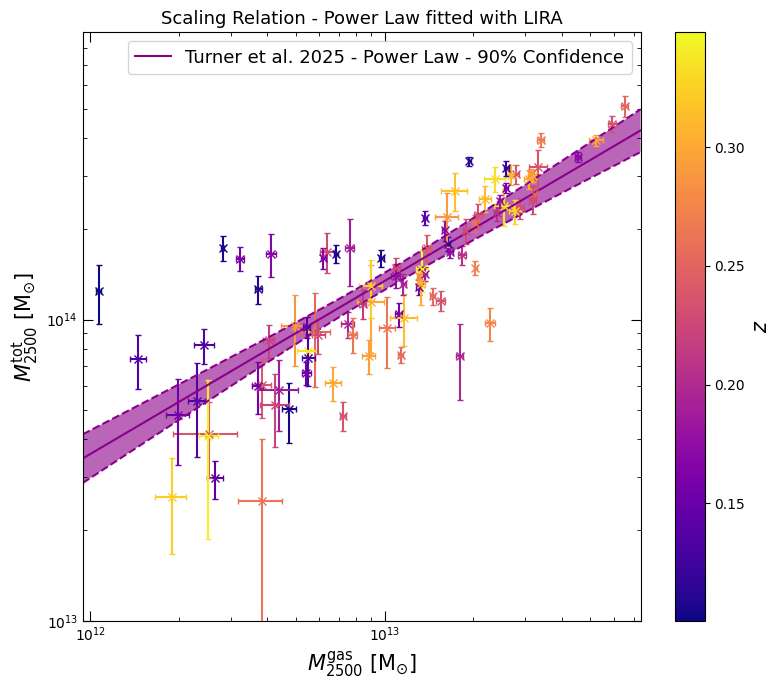

In [14]:
mtot2500_mgas2500.view(figsize=(8, 7), y_lims=Quantity([1e+13, 9e+14], 'Msun'))

## Evolution of $f_{\rm{gas}}$ with $M_{\rm{tot}}$

Though the evolution of $f_{\rm{gas}}$ with total mass (if indeed there is an evolution) is encoded in the $M^{\rm{tot}}_{500}$-$M^{\rm{gas}}_{500}$ and $M^{\rm{tot}}_{2500}$-$M^{\rm{gas}}_{2500}$ relations, we think that it is more informative to take the calculated gas fractions from earlier in this notebook, put them against total mass, and fit that relation.

In [88]:
# Make another combined dataframe with the gas-fraction information in there as well
sdssxcs_samp_gfrac = pd.merge(fgas_df[['name', 'fgas500', 'fgas500+-', 'fgas2500', 'fgas2500+-']], sdssxcs_samp, on='name')

### $f^{\rm{gas}}_{500}$-$M^{\rm{tot}}_{500}$

In [92]:
frac500 = Quantity(sdssxcs_samp_gfrac[['fgas500', 'fgas500+-', 'fgas500+-']].values)
mtot500 = Quantity(sdssxcs_samp_gfrac[['Mhy500_wraderr', 'Mhy500_wraderr-', 'Mhy500_wraderr+']].values*1e+14, 'Msun')

# Take this opportunity to add the redshift of each data point's cluster as a third data dimension
frac500_mtot500 = scaling_relation_lira(frac500[:, 0], frac500[:, 1], mtot500[:, 0], mtot500[:, 1:], Quantity(1), m_norm, 
                                        y_name=r"$f^{\rm{gas}}_{500}$", x_name=r"$M^{\rm{tot}}_{500}$", 
                                        point_names=sdssxcs_samp_gfrac['name'].values, 
                                        third_dim_info=sdssxcs_samp_gfrac['z'].values, 
                                        third_dim_name=r'$z$')
frac500_mtot500.model_colour = 'tab:blue'
frac500_mtot500.author = 'Turner et al.'
frac500_mtot500.year = 2025
frac500_mtot500.name = r'Turner et al. $f^{\rm{gas}}_{500}$-$M^{\rm{tot}}_{500}$'
# Don't save them in the same place as the other scaling relations, as these aren't really that (even though we fit them the
#  same way) - we wouldn't expect them to be used to predict the fraction from the mass, this is just a nice way to get the slope
frac500_mtot500.save("../../outputs/result_files/fgas500-mtot500_evolution.xgarel")

/Users/dt237/software/anaconda3/envs/xga_env/lib/python3.12/site-packages/xga/relations/fit.py:414: UserWarning: 46 sources have NaN values or negative uncertainties and have been excluded
  third_dim_info = _fit_initialise(y_values, y_errs, x_values, x_errs, y_norm, x_norm, True, point_names,


  |**************************************************| 100%


/Users/dt237/software/anaconda3/envs/xga_env/lib/python3.12/site-packages/xga/relations/fit.py:450: UserWarning: 46 sources have NaN values or negative uncertainties and have been excluded
  throw_away, sec_throw_away = _fit_initialise(y_values, y_errs, x_values, x_errs, y_norm, x_norm)


In [93]:
print("Slope of {v:.3f} ± {e:.3f}\n".format(v=frac500_mtot500.pars[0][0], e=frac500_mtot500.pars[0][1]))
print("Normalisation of {v:.3f} ± {e:.3f}\n".format(v=frac500_mtot500.pars[1][0], e=frac500_mtot500.pars[1][1]))
print("Scatter of {v:.3f} ± {e:.3f}".format(v=frac500_mtot500.scatter_par[0], e=frac500_mtot500.scatter_par[1]))

Slope of -0.257 ± 0.117

Normalisation of 0.114 ± 0.022

Scatter of 0.317 ± 0.025


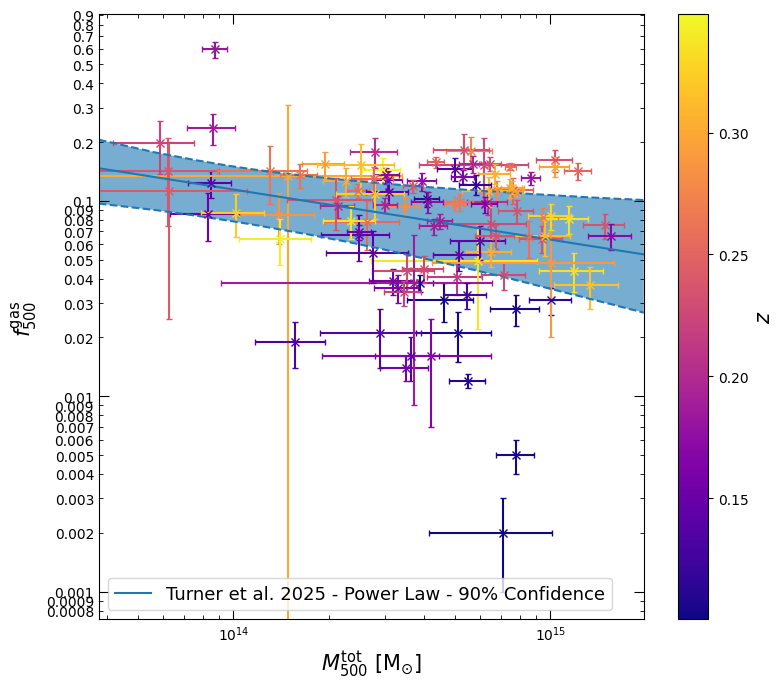

In [98]:
frac500_mtot500.view(figsize=(8, 7), log_scale=True, plot_title='', 
                     save_path="../../outputs/figures/gas_fraction/fgas500-mtot500_evolution.pdf")

### $f^{\rm{gas}}_{2500}$-$M^{\rm{tot}}_{2500}$ 

In [99]:
frac2500 = Quantity(sdssxcs_samp_gfrac[['fgas2500', 'fgas2500+-', 'fgas2500+-']].values)
mtot2500 = Quantity(sdssxcs_samp_gfrac[['Mhy2500_wraderr', 'Mhy2500_wraderr-', 'Mhy2500_wraderr+']].values*1e+14, 'Msun')

# Take this opportunity to add the redshift of each data point's cluster as a third data dimension
frac2500_mtot2500 = scaling_relation_lira(frac2500[:, 0], frac2500[:, 1], mtot2500[:, 0], mtot2500[:, 1:], Quantity(1), m_norm, 
                                          y_name=r"$f^{\rm{gas}}_{2500}$", x_name=r"$M^{\rm{tot}}_{2500}$", 
                                          point_names=sdssxcs_samp_gfrac['name'].values, 
                                          third_dim_info=sdssxcs_samp_gfrac['z'].values, 
                                          third_dim_name=r'$z$')
frac2500_mtot2500.model_colour = 'cadetblue'
frac2500_mtot2500.author = 'Turner et al.'
frac2500_mtot2500.year = 2025
frac2500_mtot2500.name = r'Turner et al. $f^{\rm{gas}}_{2500}$-$M^{\rm{tot}}_{2500}$'
# Don't save them in the same place as the other scaling relations, as these aren't really that (even though we fit them the
#  same way) - we wouldn't expect them to be used to predict the fraction from the mass, this is just a nice way to get the slope
frac2500_mtot2500.save("../../outputs/result_files/fgas2500-mtot2500_evolution.xgarel")

/Users/dt237/software/anaconda3/envs/xga_env/lib/python3.12/site-packages/xga/relations/fit.py:414: UserWarning: 59 sources have NaN values or negative uncertainties and have been excluded
  third_dim_info = _fit_initialise(y_values, y_errs, x_values, x_errs, y_norm, x_norm, True, point_names,


  |**************************************************| 100%


/Users/dt237/software/anaconda3/envs/xga_env/lib/python3.12/site-packages/xga/relations/fit.py:450: UserWarning: 59 sources have NaN values or negative uncertainties and have been excluded
  throw_away, sec_throw_away = _fit_initialise(y_values, y_errs, x_values, x_errs, y_norm, x_norm)


In [103]:
print("Slope of {v:.3f} ± {e:.3f}\n".format(v=frac2500_mtot2500.pars[0][0], e=frac2500_mtot2500.pars[0][1]))
print("Normalisation of {v:.3f} ± {e:.3f}\n".format(v=frac2500_mtot2500.pars[1][0], e=frac2500_mtot2500.pars[1][1]))
print("Scatter of {v:.3f} ± {e:.3f}".format(v=frac2500_mtot2500.scatter_par[0], e=frac2500_mtot2500.scatter_par[1]))

Slope of 0.132 ± 0.096

Normalisation of 0.075 ± 0.005

Scatter of 0.221 ± 0.019


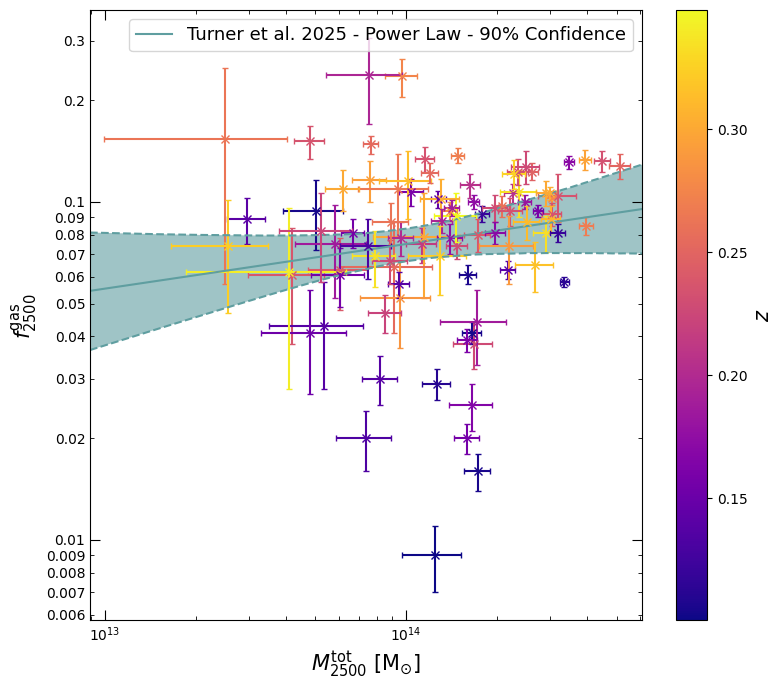

In [123]:
frac2500_mtot2500.view(figsize=(8, 7), log_scale=True, plot_title='', 
                       save_path="../../outputs/figures/gas_fraction/fgas2500-mtot2500_evolution.pdf")

### Combined contours

/Users/dt237/software/anaconda3/envs/xga_env/lib/python3.12/site-packages/xga/products/relation.py:1243: UserWarning: Not all of these ScalingRelations have the same x-axis names.
  warn('Not all of these ScalingRelations have the same x-axis names.')
/Users/dt237/software/anaconda3/envs/xga_env/lib/python3.12/site-packages/xga/products/relation.py:1250: UserWarning: Not all of these ScalingRelations have the same y-axis names.
  warn('Not all of these ScalingRelations have the same y-axis names.')


Removed no burn in
Removed no burn in


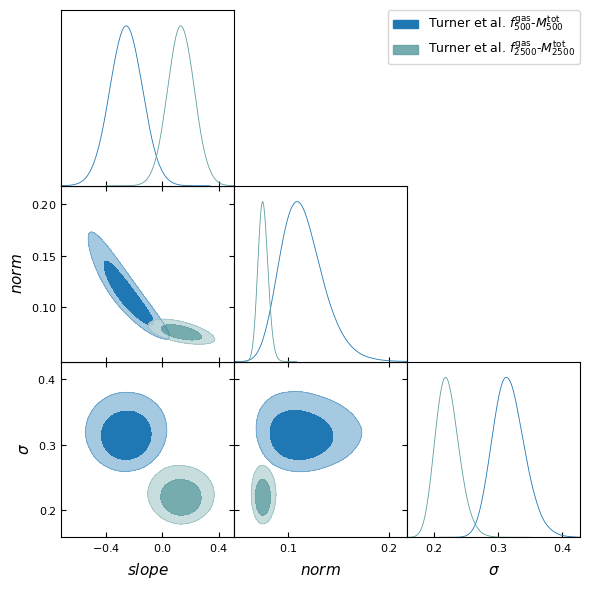

In [121]:
(frac500_mtot500 + frac2500_mtot2500).view_corner(figsize=(6, 6))

In [ ]:
stp

In [15]:
sdssxcs_base['E'] = xcs_cosmo.efunc(sdssxcs_base['z'].values)

In [16]:
sdssxcs_txlx = pd.read_csv("../../sample_files/paper_one_results/sdssrm-xcs_txlx_v1.0.0.csv")
sdssxcs_mass = pd.read_csv("../../sample_files/paper_one_results/sdssrm-xcs_mass_v1.0.0.csv")
sdssxcs_samp = pd.merge(sdssxcs_base, sdssxcs_txlx, left_on='name', right_on='name', how='outer')
sdssxcs_samp = pd.merge(sdssxcs_samp, sdssxcs_mass, left_on='name', right_on='name', how='outer')

In [24]:
r500_cut = (sdssxcs_samp['Mhy500_wraderr'] > Quantity(2, 'Msun')) & (sdssxcs_samp['Mg500_wraderr'] < Quantity(0.1, 'Msun'))
r500_samp = sdssxcs_samp[~r500_cut]

In [21]:
r2500_cut = (sdssxcs_samp['Mhy2500_wraderr'] > Quantity(1, 'Msun')) & (sdssxcs_samp['Mg2500_wraderr'] < Quantity(0.08, 'Msun'))
r2500_samp = sdssxcs_samp[~r2500_cut]

In [29]:
mtot500 = Quantity(r500_samp[['Mhy500_wraderr', 'Mhy500_wraderr-', 'Mhy500_wraderr+']].values*1e+14, 'Msun')
mgas500 = Quantity(r500_samp[['Mg500_wraderr', 'Mg500_wraderr-', 'Mg500_wraderr+']].values*1e+14, 'Msun')

mtot500_mgas500 = scaling_relation_lira(mtot500[:, 0], mtot500[:, 1:], mgas500[:, 0], mgas500[:, 1:], m_norm, mgas_norm, 
                                     y_name=r"$M^{\rm{tot}}_{500}$", x_name=r"$M^{\rm{gas}}_{500}$", 
                                     point_names=r500_samp['name'].values)
mtot500_mgas500.model_colour = 'deeppink'
mtot500_mgas500.author = 'Turner et al.'
mtot500_mgas500.year = 2025
mtot500_mgas500.name = r'Turner et al. $M^{\rm{tot}}_{500}$-$M^{\rm{gas}}_{500}$'

/Users/dt237/software/anaconda3/envs/xga_env/lib/python3.12/site-packages/xga/relations/fit.py:414: UserWarning: 46 sources have NaN values or negative uncertainties and have been excluded
  third_dim_info = _fit_initialise(y_values, y_errs, x_values, x_errs, y_norm, x_norm, True, point_names,


  |**************************************************| 100%


/Users/dt237/software/anaconda3/envs/xga_env/lib/python3.12/site-packages/xga/relations/fit.py:450: UserWarning: 46 sources have NaN values or negative uncertainties and have been excluded
  throw_away, sec_throw_away = _fit_initialise(y_values, y_errs, x_values, x_errs, y_norm, x_norm)


In [33]:
print("Slope of {v:.3f} ± {e:.3f}\n".format(v=mtot500_mgas500.pars[0][0], e=mtot500_mgas500.pars[0][1]))
print("Normalisation of {v:.3f} ± {e:.3f}\n".format(v=mtot500_mgas500.pars[1][0], e=mtot500_mgas500.pars[1][1]))
print("Scatter of {v:.3f} ± {e:.3f}".format(v=mtot500_mgas500.scatter_par[0], e=mtot500_mgas500.scatter_par[1]))

Slope of 0.650 ± 0.064

Normalisation of 1.802 ± 0.181

Scatter of 0.201 ± 0.017


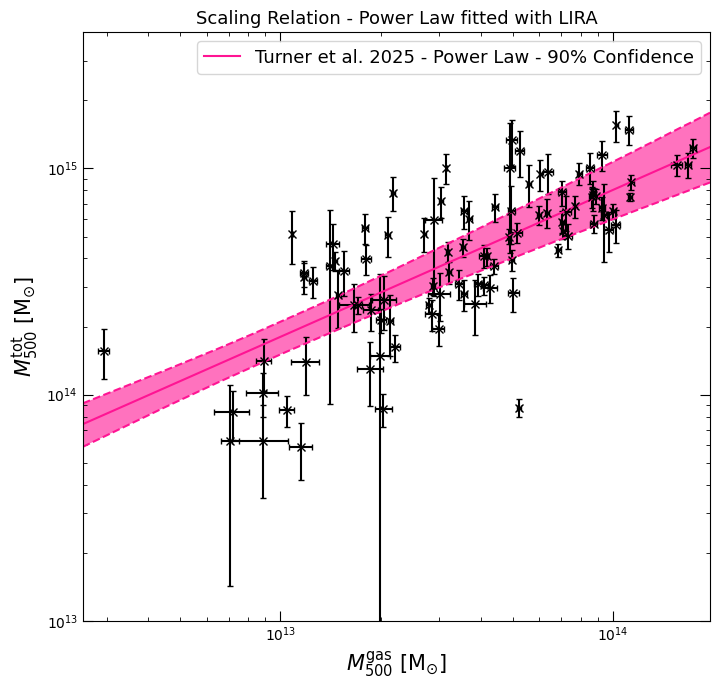

In [30]:
mtot500_mgas500.view(figsize=(7.3, 7), y_lims=Quantity([1e+13, 4e+15], 'Msun'))

In [31]:
mtot2500 = Quantity(r2500_samp[['Mhy2500_wraderr', 'Mhy2500_wraderr-', 'Mhy2500_wraderr+']].values*1e+14, 'Msun')
mgas2500 = Quantity(r2500_samp[['Mg2500_wraderr', 'Mg2500_wraderr-', 'Mg2500_wraderr+']].values*1e+14, 'Msun')

mtot2500_mgas2500 = scaling_relation_lira(mtot2500[:, 0], mtot2500[:, 1:], mgas2500[:, 0], mgas2500[:, 1:], m_norm, mgas_norm, 
                                     y_name=r"$M^{\rm{tot}}_{2500}$", x_name=r"$M^{\rm{gas}}_{2500}$", 
                                     point_names=r2500_samp['name'].values)
mtot2500_mgas2500.model_colour = 'darkmagenta'
mtot2500_mgas2500.author = 'Turner et al.'
mtot2500_mgas2500.year = 2025
mtot2500_mgas2500.name = r'Turner et al. $M^{\rm{tot}}_{2500}$-$M^{\rm{gas}}_{2500}$'

/Users/dt237/software/anaconda3/envs/xga_env/lib/python3.12/site-packages/xga/relations/fit.py:414: UserWarning: 59 sources have NaN values or negative uncertainties and have been excluded
  third_dim_info = _fit_initialise(y_values, y_errs, x_values, x_errs, y_norm, x_norm, True, point_names,


  |**************************************************| 100%


/Users/dt237/software/anaconda3/envs/xga_env/lib/python3.12/site-packages/xga/relations/fit.py:450: UserWarning: 59 sources have NaN values or negative uncertainties and have been excluded
  throw_away, sec_throw_away = _fit_initialise(y_values, y_errs, x_values, x_errs, y_norm, x_norm)


In [34]:
print("Slope of {v:.3f} ± {e:.3f}\n".format(v=mtot2500_mgas2500.pars[0][0], e=mtot2500_mgas2500.pars[0][1]))
print("Normalisation of {v:.3f} ± {e:.3f}\n".format(v=mtot2500_mgas2500.pars[1][0], e=mtot2500_mgas2500.pars[1][1]))
print("Scatter of {v:.3f} ± {e:.3f}".format(v=mtot2500_mgas2500.scatter_par[0], e=mtot2500_mgas2500.scatter_par[1]))

Slope of 0.727 ± 0.039

Normalisation of 1.202 ± 0.040

Scatter of 0.105 ± 0.011


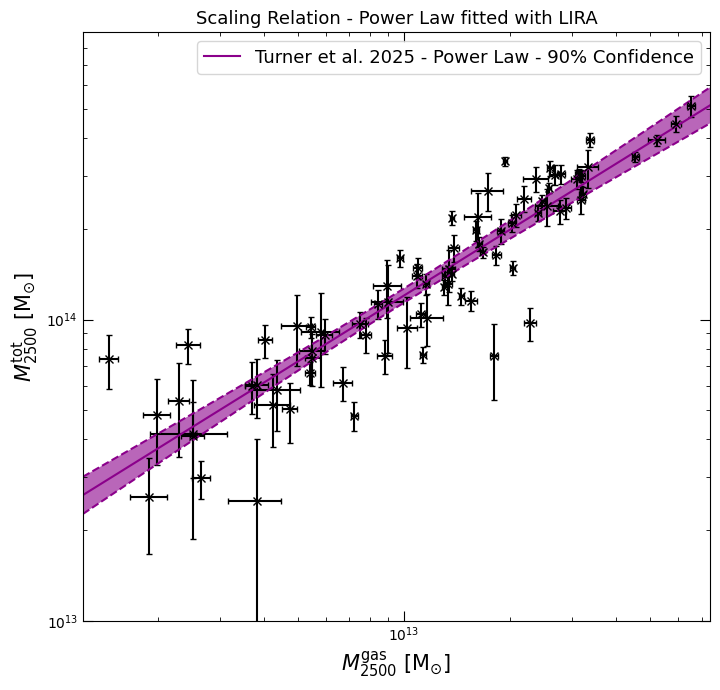

In [32]:
mtot2500_mgas2500.view(figsize=(7.3, 7), y_lims=Quantity([1e+13, 9e+14], 'Msun'))

In [37]:
mtot2500_mgas2500.predict(Quantity(1e+13, 'Msun'), x_errors=Quantity(0, 'Msun'))

<Quantity [1.20210511e+14, 4.01895662e+12] solMass>